In [1]:
from keras import Sequential
from keras.engine.saving import model_from_json
from keras.optimizers import Adam
from keras.utils import plot_model
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Embedding, Conv1D, MaxPooling1D, Dropout, LSTM, RepeatVector, GlobalMaxPooling1D, \
    Concatenate, UpSampling2D, UpSampling1D, concatenate
from keras.models import Model
from load_dataset import Load_Dataset
from sklearn.metrics import accuracy_score,classification_report
X,y,class_names = Load_Dataset.load_hate_speech()
#X,y,class_names = Load_Dataset.load_smsspam()

Using TensorFlow backend.


Firstly, lets load our first test dataset "Hate Speech".

In [2]:
X_train, X_test ,y_train ,y_test = train_test_split(X,y, random_state=70, stratify=y, test_size=0.33)
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

Now we split it into train and test sets

In [3]:
vec = TfidfVectorizer(max_features=5000)
vec.fit(X_train_copy)
X_train_copy = vec.transform(X_train_copy)
X_test_copy = vec.transform(X_test_copy)

We will use a typical vec transform for the LioNet

But first we have to train out autoencoder!

In [4]:
input_dim = len(vec.get_feature_names())
autoencoder_input = Input(shape=(input_dim,))
autoencoder_x = Dense(800, activation='relu')(autoencoder_input)
autoencoder_x = Dropout(0.2)(autoencoder_x)
autoencoder_x = Dense(600, activation='relu')(autoencoder_x)
autoencoder_x = Dense(400, activation='relu')(autoencoder_x)
autoencoder_x = Dense(800, activation='relu')(autoencoder_x)
autoencoder_output = Dense(input_dim, activation='sigmoid')(autoencoder_x)
autoencoder = Model(autoencoder_input, autoencoder_output)

autoencoder.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
print(autoencoder.summary())
autoencoder.fit(X_train_copy, X_train_copy, epochs=100, batch_size=64, shuffle=True, 
                validation_data=(X_test_copy, X_test_copy),verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2028)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 800)               1623200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 600)               480600    
_________________________________________________________________
dense_3 (Dense)              (None, 400)               240400    
_________________________________________________________________
dense_4 (Dense)              (None, 800)               320800    
_________________________________________________________________
dense_5 (Dense)              (None, 2028)              1624428   
Total para

 - 0s - loss: 15.5638 - acc: 0.0033 - val_loss: 31.4238 - val_acc: 0.0200
Epoch 81/100
 - 0s - loss: 15.5603 - acc: 0.0033 - val_loss: 32.4979 - val_acc: 0.0200
Epoch 82/100
 - 0s - loss: 15.5503 - acc: 0.0033 - val_loss: 31.9032 - val_acc: 0.0200
Epoch 83/100
 - 0s - loss: 15.5391 - acc: 0.0033 - val_loss: 32.6574 - val_acc: 0.0200
Epoch 84/100
 - 0s - loss: 15.5248 - acc: 0.0033 - val_loss: 31.5304 - val_acc: 0.0200
Epoch 85/100
 - 0s - loss: 15.5121 - acc: 0.0033 - val_loss: 32.1215 - val_acc: 0.0200
Epoch 86/100
 - 0s - loss: 15.5052 - acc: 0.0033 - val_loss: 32.2779 - val_acc: 0.0200
Epoch 87/100
 - 0s - loss: 15.4778 - acc: 0.0033 - val_loss: 32.0071 - val_acc: 0.0200
Epoch 88/100
 - 0s - loss: 15.4649 - acc: 0.0033 - val_loss: 31.9029 - val_acc: 0.0200
Epoch 89/100
 - 0s - loss: 15.4629 - acc: 0.0033 - val_loss: 31.8634 - val_acc: 0.0200
Epoch 90/100
 - 0s - loss: 15.4556 - acc: 0.0033 - val_loss: 32.5192 - val_acc: 0.0200
Epoch 91/100
 - 0s - loss: 15.4538 - acc: 0.0033 - val_l

Now lets seperate the encoder from our encoder

In [5]:
input_text = Input(shape=(input_dim,))
encoder_layer = autoencoder.layers[1](input_text)
encoder_layer = autoencoder.layers[2](encoder_layer)
encoder_layer = autoencoder.layers[3](encoder_layer)
encoder_layer = autoencoder.layers[4](encoder_layer)
encoder = Model(input_text, encoder_layer)

We have the encoder so we can encode our data

In [6]:
encoded_train = encoder.predict(X_train_copy)
decoded_train = autoencoder.predict(X_train_copy)

encoded_test = encoder.predict(X_test_copy)
decoded_test = autoencoder.predict(X_test_copy)

In [7]:
new_x_train = encoded_train
new_x_test = encoded_test

input_text = Input(shape=(400,))
predictions = Dense(1, activation='sigmoid')(input_text)

predictor = Model(input_text,predictions)
predictor.compile(optimizer=Adam(),loss=["binary_crossentropy"],metrics=['accuracy'])
print(predictor.summary())
predictor.fit([new_x_train], [y_train], validation_data=(new_x_test,y_test), epochs=20, verbose=2)  # starts training
y_preds = predictor.predict(new_x_test)
y_pred = []
for i in y_preds:
    if i>0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 400)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 401       
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________
None
Train on 304 samples, validate on 150 samples
Epoch 1/20
 - 0s - loss: 1.9458 - acc: 0.5921 - val_loss: 1.0748 - val_acc: 0.6467
Epoch 2/20
 - 0s - loss: 1.4817 - acc: 0.5822 - val_loss: 0.8881 - val_acc: 0.6200
Epoch 3/20
 - 0s - loss: 1.2123 - acc: 0.5428 - val_loss: 0.7475 - val_acc: 0.6533
Epoch 4/20
 - 0s - loss: 0.9777 - acc: 0.6480 - val_loss: 0.6492 - val_acc: 0.6800
Epoch 5/20
 - 0s - loss: 0.7795 - acc: 0.6447 - val_loss: 0.6034 - val_acc: 0.7333
Epoch 6/20
 - 0s - loss: 0.6996 - acc: 0.6875 - val_loss: 0.5744 - val_acc

/Users/johnmollas/Desktop/MScProjects/venv3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [8]:
input_text = Input(shape=(400,))
decoder_layer = autoencoder.layers[5](input_text)
decoder_layer = autoencoder.layers[6](decoder_layer)
decoder = Model(input_text, decoder_layer)
decoder.summary()
decoded_train = decoder.predict(encoded_train)
decoded_test = decoder.predict(encoded_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 400)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 800)               320800    
_________________________________________________________________
dense_5 (Dense)              (None, 2028)              1624428   
Total params: 1,945,228
Trainable params: 1,945,228
Non-trainable params: 0
_________________________________________________________________


at moment like this where know that wish think is useless wish wa presid of countri with economi strong enough to help out also am the last person to be presid consid my psycholog state and other stuff but yeah feel so helpless right now
[[0.12857796]]
The predictor classified: [0.12857796]
The fidelity of the LioNet in terms of accuracy is: 0


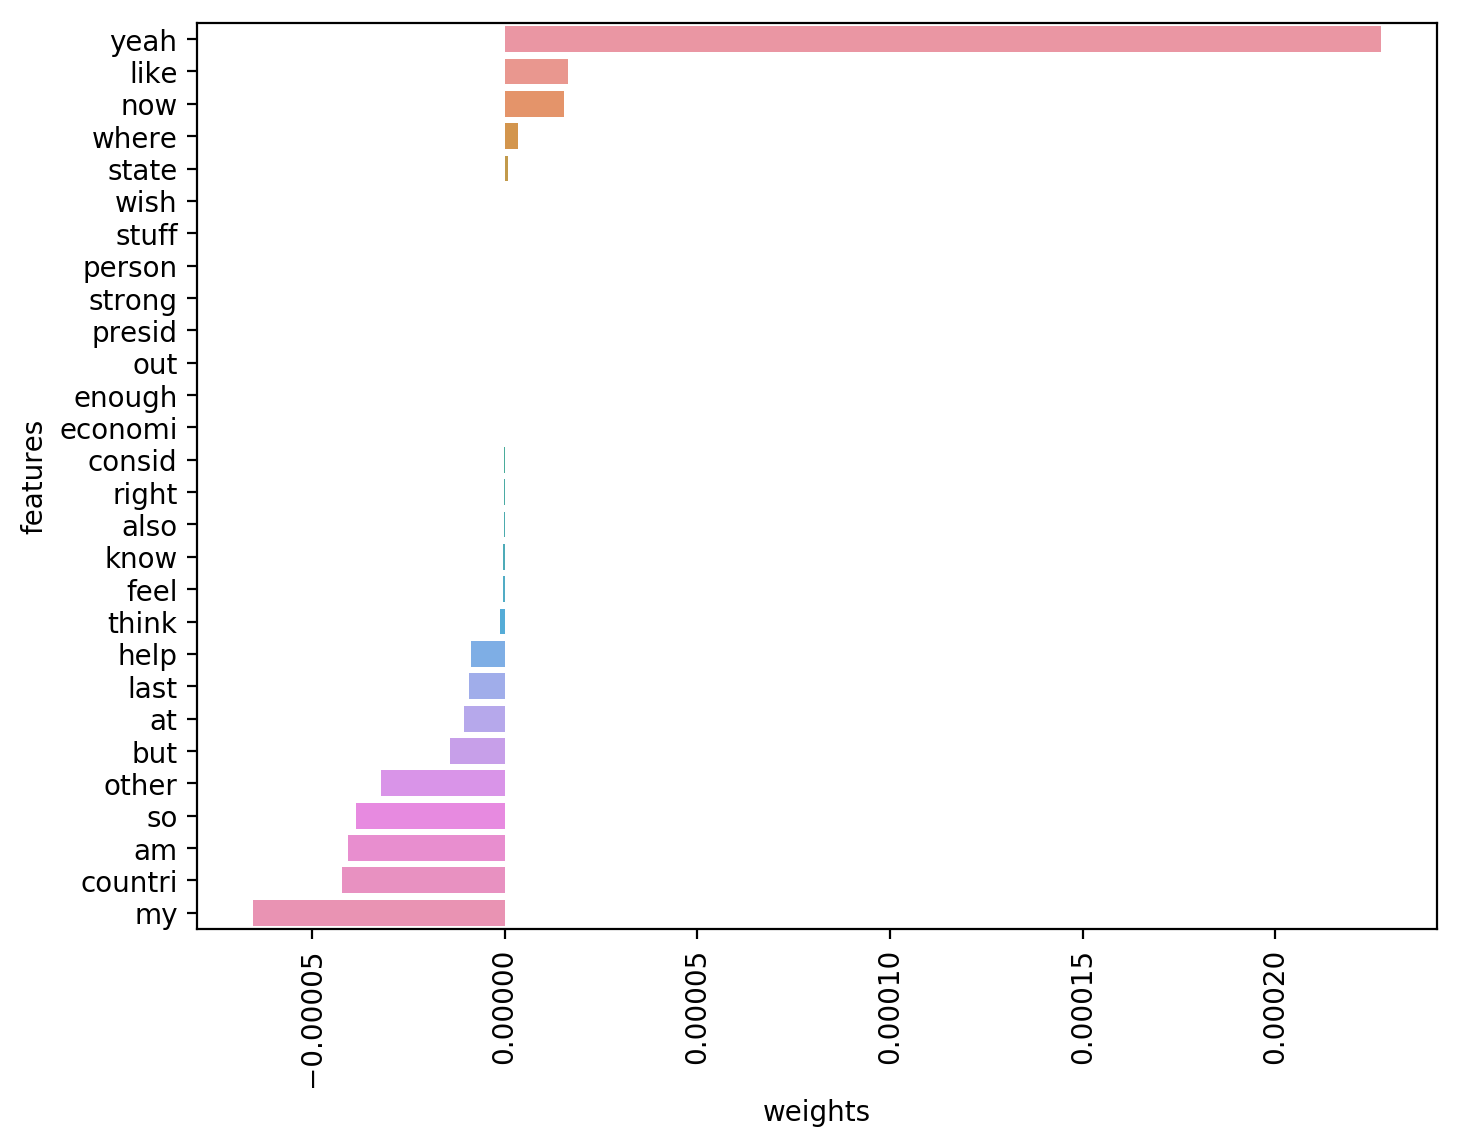

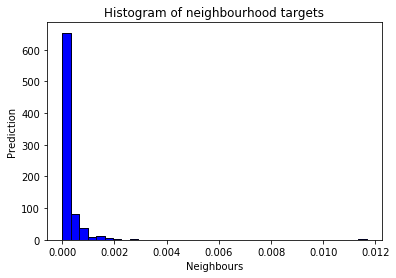

In [12]:
from LioNets import LioNet
%matplotlib inline  
lionet = LioNet(predictor,autoencoder,decoder,encoder, vec.get_feature_names())
print(X_test[20])
lionet.explain_instance(X_test_copy[20])
lionet.print_neighbourhood_labels_distribution()
#lionet.accuracy

if he didn 39;t have that gun he would have been kill with that shovel yet he doesn 39;t shoot the scum so they can kill the next white person they find rip franc
[[0.03930293]]
The predictor classified: [0.03930293]
The fidelity of the LioNet in terms of accuracy is: 0


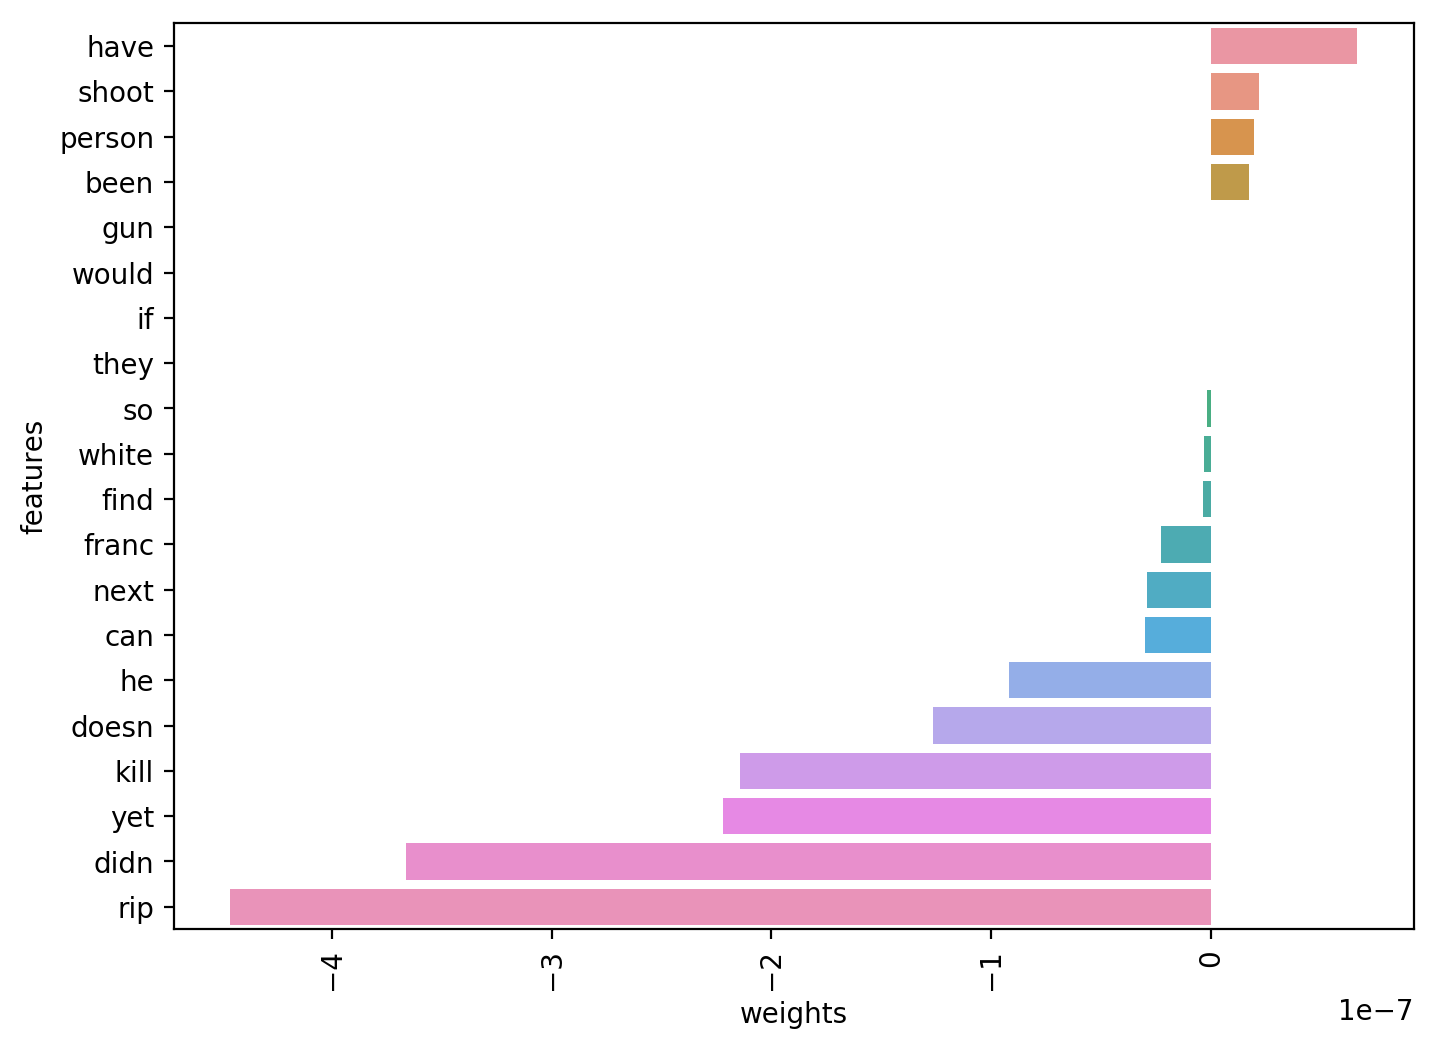

True

In [10]:
from LioNets import LioNet
%matplotlib inline  
lionet = LioNet(predictor,autoencoder,decoder,encoder, vec.get_feature_names())
print(X_train[0])
lionet.explain_instance(vec.transform(["if he didn 39;t have that gun he would have been kill with that yet he doesn 39;t shoot the so they can kill the next white person they find rip franc"]))
#lionet.accuracy

In [ ]:
from collections import OrderedDict
import re
import time
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

input_text = Input(shape=(input_dim,))
lime_predictor = encoder(input_text)
lime_predictor = Dense(1, activation='sigmoid')(lime_predictor)
lime_model = Model(input_text,lime_predictor)
lime_model.compile(optimizer=Adam(),loss=["binary_crossentropy"],metrics=['accuracy'])
lime_model.fit([X_train_copy], [y_train], validation_data=(X_test_copy,y_test), epochs=20, verbose=2)  # starts training
y_preds = lime_model.predict(X_test_copy)
y_pred = []
for i in y_preds:
    if i>0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

pipeline = make_pipeline(vec, lime_model)

start = time.time()
idx = 20
newXtest = X_test[idx]
y_true = y_test[idx]
y_pp = y_preds[idx]
split_expression = lambda s: re.split(r'\W+', s)
explainer = LimeTextExplainer(class_names=class_names, split_expression=split_expression)
explanation = explainer.explain_instance(newXtest, pipeline.predict, num_features=20)
weights = OrderedDict(explanation.as_list())
lime_w = pd.DataFrame({'words': list(weights.keys()), 'weights': list(weights.values())})
sns.barplot(x="words", y="weights", data=lime_w)
plt.xticks(rotation=45)
print('Instance:',X_test_copy[20])
print('Predictor classified:',str(y_pp))
print('True class:',str(y_true))
plt.show()
stop = time.time()
limeTime = stop - start

In [ ]:
from sklearn.pipeline import make_pipeline
from keras.wrappers.scikit_learn import KerasClassifier

input_text = Input(shape=(input_dim,))
lime_predictor = encoder(input_text)
lime_predictor = Dense(1, activation='sigmoid')(lime_predictor)
lime_model = Model(input_text,lime_predictor)
lime_model.compile(optimizer=Adam(),loss=["binary_crossentropy"],metrics=['accuracy'])

lime_model.fit(X_train, y_train)
y_preds = pipeline.predict(X_test)
y_pred = []
for i in y_preds:
    if i>0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

In [1]:
from collections import OrderedDict
import re
import time
from lime.lime_text import LimeTextExplainer

start = time.time()
idx = 20
newXtest = X_test[idx]
y_true = y_test[idx]
y_pp = y_preds[idx]
split_expression = lambda s: re.split(r'\W+', s)
explainer = LimeTextExplainer(class_names=target_names, split_expression=split_expression)
explanation = explainer.explain_instance(newXtest, pipeline.predict_proba, num_features=20)
weights = OrderedDict(explanation.as_list())
lime_w = pd.DataFrame({'words': list(weights.keys()), 'weights': list(weights.values())})
sns.barplot(x="words", y="weights", data=lime_w)
plt.xticks(rotation=45)
print('Instance:',X_test_copy[20])
print('Predictor classified:',str(y_pp))
print('True class:',str(y_true))
plt.show()
stop = time.time()
limeTime = stop - start

NameError: name 'X_test' is not defined